# Complexity Measures of EEG Data
This notebook demonstrates the computation and comparison of several complexity measures (correlation dimension, spectral entropy, permutation entropy, Lempel-Ziv complexity, and multiscale entropy) on EEG data from an antidepressant study. The workflow includes data loading, preprocessing, and group-wise statistical analysis.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import sys
sys.path.append('..')
import complexitylib as complex

## Data Preprocessing
Load patient cluster assignments and prepare the patient list for analysis.

In [2]:
# Load cluster assignments
file_path = '../output/patients_clusters.csv'
clusters = np.loadtxt(file_path, delimiter=',', skiprows=1, dtype=str)

# Create Patient objects
patients = []
for i, pat in enumerate(clusters):
    patients.append(complex.Patient(name=pat[0], cluster=int(pat[1]), id=i))

# Exclude patients with missing or corrupted recordings
patients = [p for p in patients if p.name not in ['DD09', 'DD28', 'DD45', 'DD53']]

## Load and Organize EEG Data
Extract pre- and post-treatment EEG recordings for each patient and organize them by cluster and condition.

In [3]:
# For each cluster, collect pre- and post-treatment EEG data
aggregate_data = []
group_labels = []
conditions = []
unique_clusters = set(p.cluster for p in patients)
for i in range(len(unique_clusters)):
    patients_in_cluster = [p for p in patients if p.cluster == i]
    group_data = []
    for pat in patients_in_cluster:
        signal, channels = pat.get_eeg_before()
        group_data.append(signal.tolist())
        group_labels.append(pat.cluster)
        conditions.append('pre')
    aggregate_data.append(group_data)
    group_data = []
    for pat in patients_in_cluster:
        signal, channels = pat.get_eeg_after()
        group_data.append(signal.tolist())
        group_labels.append(pat.cluster)
        conditions.append('post')
    aggregate_data.append(group_data)

## Truncate Signals to Uniform Length
Find the shortest signal and truncate all signals to this length for consistency across subjects and channels.

In [4]:
# Find the shortest signal in aggregate_data
min_length = min([len(signal) for group in aggregate_data for channel in group for signal in channel])
# Truncate all signals to min_length
for group in aggregate_data:
    for channel in group:
        for i, signal in enumerate(channel):
            channel[i] = signal[:min_length]

## Downsample Data for Computational Efficiency
Downsample all EEG signals by truncating the signal after 10,000 time steps for computationally intensive analyses.

In [5]:
# Concatenate and downsample EEG data
eeg_data_all = np.concatenate(aggregate_data, axis=0)
eeg_data_downsample = np.zeros((eeg_data_all.shape[0], eeg_data_all.shape[1], 10000))
for i in range(eeg_data_all.shape[0]):
    for j in range(eeg_data_all.shape[1]):
        eeg_data_downsample[i, j] = eeg_data_all[i, j, :10000]
eeg_data_downsample.shape

(92, 32, 10000)

## Correlation Dimension Analysis
Compute and compare the correlation dimension of EEG signals across groups and conditions.

In [ ]:
def compare_6_groups(eeg_data, group_labels, conditions, m=5, tau=1):
    """
    Compute and plot mean correlation dimension for each group and condition.
    """
    from collections import defaultdict
    group_data = defaultdict(list)
    for i in range(eeg_data.shape[0]):
        dims = complex.compute_subject_dims(eeg_data[i], m=m, tau=tau)
        mean_dim = np.mean(dims)
        key = (group_labels[i], conditions[i])
        group_data[key].append(mean_dim)
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[key] for key in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]
    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Mean Correlation Dimension")
    plt.title("Correlation Dimension: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return group_data

# Run analysis
results = compare_6_groups(eeg_data_downsample, group_labels, conditions, m=8, tau=2)

## Spectral Entropy Analysis
Compute and compare spectral entropy across groups and conditions using the AntroPy library.

C:\Users\aless\AppData\Local\Temp\ipykernel_20392\3648016168.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


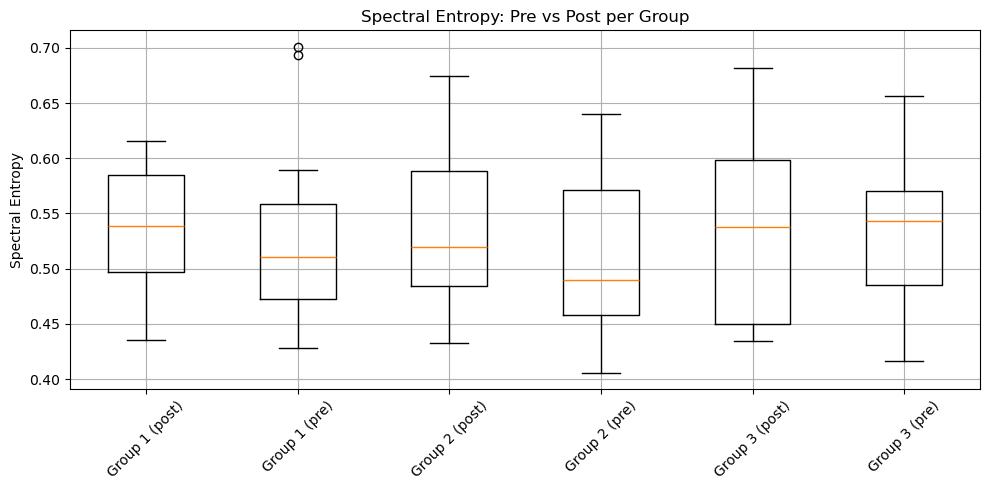

In [6]:
from antropy import spectral_entropy
from collections import defaultdict

def compute_subject_spen(eeg_subject, sf=500, method='welch', normalize=True):
    return np.mean([
        spectral_entropy(eeg_subject[ch], sf=sf, method=method, normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])

def compare_6_groups_spen(eeg_data, group_labels, conditions, sf=500):
    group_data = defaultdict(list)
    for i in range(len(eeg_data)):
        spen = compute_subject_spen(eeg_data[i], sf=sf)
        key = (group_labels[i], conditions[i])
        group_data[key].append(spen)
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]
    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Spectral Entropy")
    plt.title("Spectral Entropy: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return group_data

sf = 500  # sampling frequency in Hz
spen_results = compare_6_groups_spen(eeg_data_all, group_labels, conditions, sf=sf)

## Permutation Entropy Analysis
Compute and compare permutation entropy across groups and conditions.

C:\Users\aless\AppData\Local\Temp\ipykernel_20392\2501132935.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


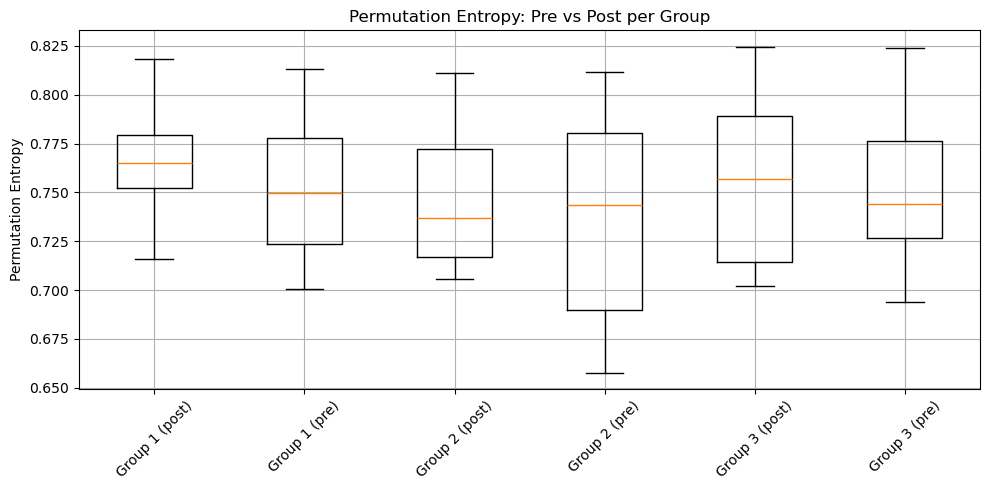

In [7]:
from antropy import perm_entropy

def compute_subject_permen(eeg_subject, order=3, delay=1, normalize=True):
    return np.mean([
        perm_entropy(eeg_subject[ch], order=order, delay=delay, normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])

def compare_6_groups_permen(eeg_data, group_labels, conditions, order=3, delay=1):
    from collections import defaultdict
    group_data = defaultdict(list)
    for i in range(len(eeg_data)):
        pe = compute_subject_permen(eeg_data[i], order=order, delay=delay)
        key = (group_labels[i], conditions[i])
        group_data[key].append(pe)
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]
    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Permutation Entropy")
    plt.title("Permutation Entropy: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return group_data

permen_results = compare_6_groups_permen(eeg_data_all, group_labels, conditions)

## Lempel-Ziv Complexity Analysis
Compute and compare Lempel-Ziv complexity across groups and conditions.

C:\Users\aless\AppData\Local\Temp\ipykernel_20392\2856272811.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


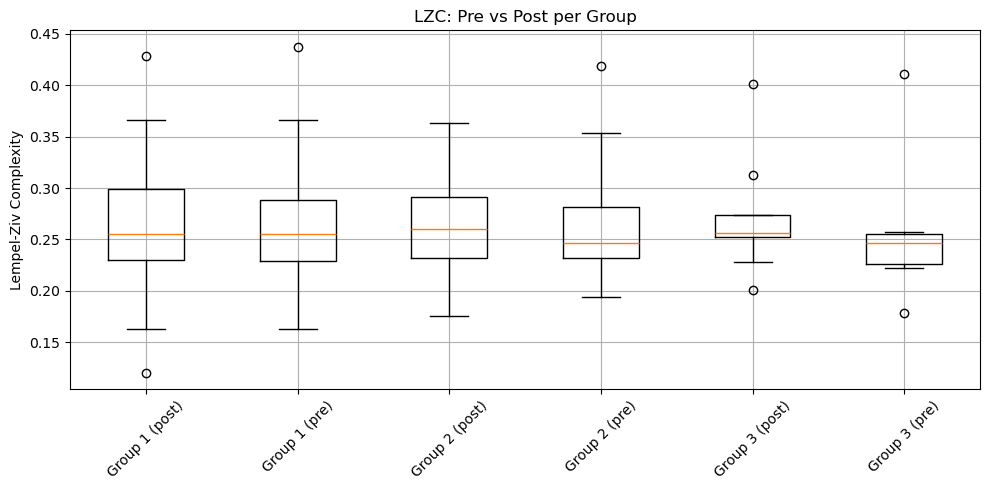

In [8]:
from antropy import lziv_complexity

def compute_subject_lzc(eeg_subject, normalize=True):
    return np.mean([
        lziv_complexity((eeg_subject[ch] > np.mean(eeg_subject[ch])).astype(int), normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])

def compare_6_groups_lzc(eeg_data, group_labels, conditions, normalize=True):
    from collections import defaultdict
    group_data = defaultdict(list)
    for i in range(len(eeg_data)):
        lzc = compute_subject_lzc(eeg_data[i], normalize=normalize)
        key = (group_labels[i], conditions[i])
        group_data[key].append(lzc)
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]
    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Lempel-Ziv Complexity")
    plt.title("LZC: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return group_data

lzc_results = compare_6_groups_lzc(eeg_data_all, group_labels, conditions)

## Multiscale Entropy Analysis
Downsample the data and compute multiscale entropy (MSE) curves for each group and condition.

In [9]:
from scipy.signal import decimate

def downsample_eeg(eeg_data, factor=4):
    n_subjects, n_channels, _ = eeg_data.shape
    return np.array([
        [decimate(eeg_data[s, c], factor, ftype='fir', zero_phase=True)
         for c in range(n_channels)]
        for s in range(n_subjects)
    ])

# Downsampling the data instead of truncating it
eeg_data_MSE = downsample_eeg(eeg_data_all, 4)
eeg_data_MSE.shape

(92, 32, 22400)

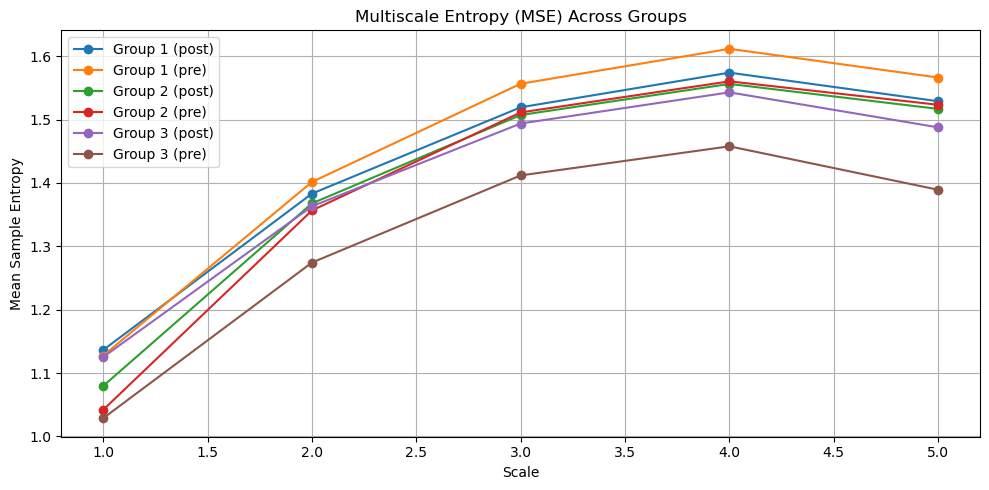

In [10]:
from antropy import sample_entropy

def multiscale_entropy(signal, max_scale=5, m=2):
    mse = []
    for scale in range(1, max_scale + 1):
        if len(signal) < scale:
            mse.append(np.nan)
            continue
        n = len(signal) // scale
        coarse = np.mean(signal[:n * scale].reshape(n, scale), axis=1)
        se = sample_entropy(coarse, order=m)
        mse.append(se)
    return np.array(mse)

def compute_subject_mse(eeg_subject, max_scale=5, m=2):
    channel_mse = np.array([
        multiscale_entropy(eeg_subject[ch], max_scale=max_scale, m=m)
        for ch in range(eeg_subject.shape[0])
    ])
    return np.nanmean(channel_mse, axis=0)

from collections import defaultdict

def compare_mse_6_groups(eeg_data, group_labels, conditions, max_scale=5, m=2):
    group_data = defaultdict(list)
    for i in range(len(eeg_data)):
        mse = compute_subject_mse(eeg_data[i], max_scale=max_scale, m=m)
        key = (group_labels[i], conditions[i])
        group_data[key].append(mse)
    all_keys = sorted(group_data.keys())
    plt.figure(figsize=(10, 5))
    for key in all_keys:
        label = f"Group {key[0]+1} ({key[1]})"
        data = np.array(group_data[key])
        mean_curve = np.nanmean(data, axis=0)
        plt.plot(range(1, max_scale+1), mean_curve, marker='o', label=label)
    plt.xlabel("Scale")
    plt.ylabel("Mean Sample Entropy")
    plt.title("Multiscale Entropy (MSE) Across Groups")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return group_data

# Run group comparison
mse_results = compare_mse_6_groups(eeg_data_MSE, group_labels, conditions, max_scale=5, m=2)

---

**Summary:**
This notebook provides a reproducible pipeline for computing and comparing multiple complexity measures on EEG data, including correlation dimension, spectral entropy, permutation entropy, Lempel-Ziv complexity, and multiscale entropy. The workflow supports group-wise and condition-wise analysis for clinical neuroscience research.